# Analyzing Stock Price Volatility and Predicting Price Movements

GOAL:

The objective of this project is to analyze NVIDIA's historical stock price data, measure volatility, and build a predictive model to forecast future price movements.

I found interest in NVIDIA because it was part of my investment portfolio before the recent spike in stock price. I speculated a rise in price when the CHIPS act was passed, which provided over 200 billion dollars in research funding for the manufacturing of semiconductor chips in the US. However, I'm curious to see if my analysis of the stock could provide financial indicators of price hikes.

## Data Collection

For this project, I chose to use the Yahoo finance API to retrieve data on NVIDIA as the website is familiar to me, allowing me to navigate an interface while conducting my analysis. I chose to use the pandas datareader to gain access to a broader range of data sources from the web, including the World Bank's World Development Indicators (WDI) database. The WDI database contains a wide range of economic, social, and environmental indicators for various countries over time.

In [5]:
# Installing dependencies

# ! pip install pandas-datareader 
# ! pip install yfinance
# ! pip install Tiingo
# ! pip install requests
# !pip install pyforest

In [6]:
# Importing necessary libraries

import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
import matplotlib.pyplot as plt
import tiingo
import requests

## Exploratory Data Analysis

In [7]:
# Setting the start and end dates for the data to look back five years
start_date = '2019-01-01'
end_date = '2023-06-24'

# Fetching the historical stock price data using yfinance
nvidia_data = yf.download('NVDA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [8]:
# Display the first few rows of the data
print(nvidia_data.head())

# Check the data types of the columns
nvidia_data.info()

# Perform basic statistical analysis
nvidia_data.describe()

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-01-02  32.660000  34.619999  32.512501  34.055000  33.796234  50875200
2019-01-03  33.447498  33.790001  31.922501  31.997499  31.754362  70555200
2019-01-04  32.735001  34.432499  32.424999  34.047501  33.788784  58562000
2019-01-07  34.625000  36.222500  34.107498  35.849998  35.577591  70916000
2019-01-08  36.672501  36.695000  34.224998  34.957500  34.691879  78601600
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1127 entries, 2019-01-02 to 2023-06-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1127 non-null   float64
 1   High       1127 non-null   float64
 2   Low        1127 non-null   float64
 3   Close      1127 non-null   float64
 4   Adj Close  1127 non-null   float64
 5   Volume     1127 non-null   int64  
dtypes: float64(5), int6

,Open,High,Low,Close,Adj Close,Volume
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1.127000e+03
mean,145.150845,148.039641,142.268032,145.306513,145.086012,4.630508e+07
std,85.584619,87.390874,83.722697,85.629478,85.646332,2.049014e+07
min,32.660000,33.790001,31.922501,31.997499,31.754362,9.788400e+06
25%,62.188749,63.273750,61.068750,62.112499,61.881269,3.186180e+07
50%,136.065002,138.380005,133.460007,135.582504,135.358353,4.328170e+07
75%,199.762497,204.088753,196.788757,200.146248,199.844910,5.695925e+07
max,435.010010,439.899994,426.739990,438.079987,438.079987,2.511528e+08


Interestingly, EDA reflects the stock price hike to some extent, with the 75th percentile of all 1127 records being less than half of the current price (about 420 USD today). In the data visualization section (next), we will see this hike, which is relatively abrupt.  

## Data Visualization

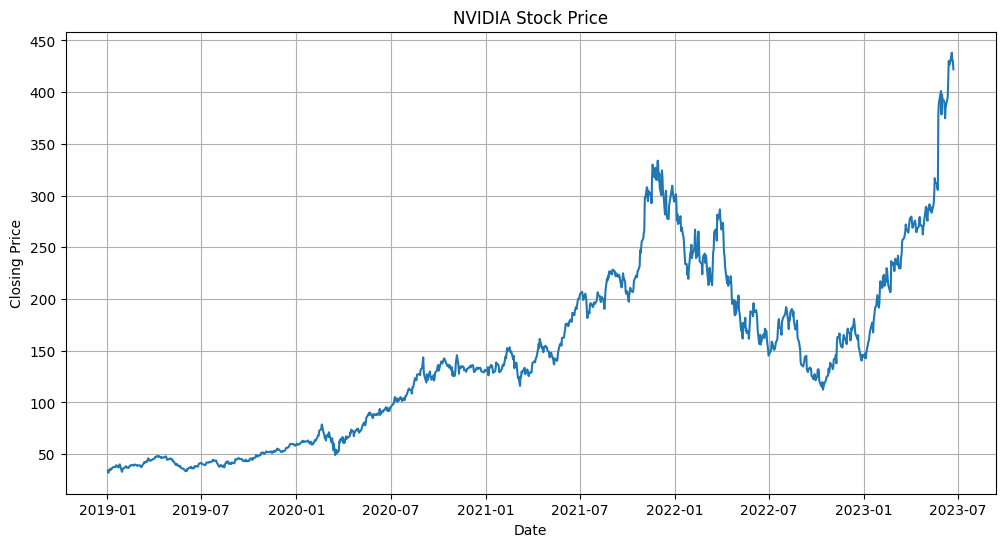

In [9]:
# Plotting the closing price over time
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['Close'])
plt.title('NVIDIA Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

### Volatility Analysis
Now analyzing the volatility of NVIDIA through the standard deviation of returns. I use a window of 30 in the rolling standard deviation to reflect monthly volitility.

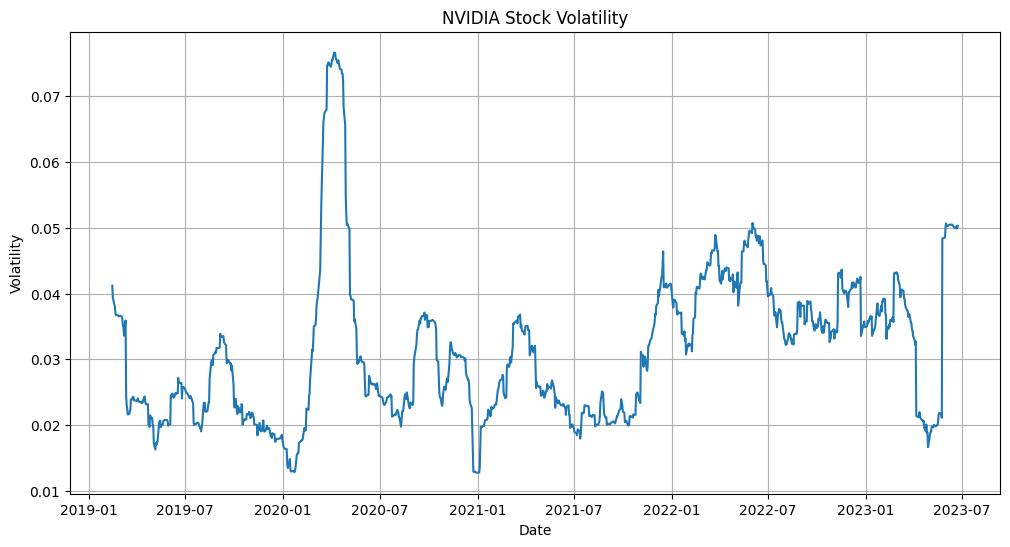

In [10]:
# Looking at daily returns 
nvidia_data['Daily_Return'] = nvidia_data['Close'].pct_change()

# Calculating volatility by looking at the std of daily returns over a period of 30 days
window_size = 30  
nvidia_data['Volatility'] = nvidia_data['Daily_Return'].rolling(window_size).std()

# Visualizing volatility for analysis
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['Volatility'])
plt.title('NVIDIA Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [11]:
nvidia_data['Volatility'].describe()

count    1097.000000
mean        0.031272
std         0.011466
min         0.012758
25%         0.022149
50%         0.029925
75%         0.037168
max         0.076634
Name: Volatility, dtype: float64

Notable patterns in volatility and stock price: Dips in volatility usually correspond to plateus in price, while spikes correspond to lower prices. Looking at the statistical analysis of stock volatility, we can reasonable assume that a volatility greater than the 75th percentile is 'high', while a volatility lower than the 25th percentile is 'low'. 

## Feature Engineering

With the goal of capturing technical and non-technical indicators of price hikes, I will include the relative strength index (RSI) to record momentum for my technical indicator and a medium of financial news sentiment analysis for my non-technical indicator.

In [12]:
# Building RSI to capture the speed and change of price movements using historical data
# Calculate price change
nvidia_data['Price_Change'] = nvidia_data['Close'].diff()

# Define the lookback period (14 days)
lookback_period = 14

# Calculate the average gain and average loss
nvidia_data['Gain'] = nvidia_data['Price_Change'].where(nvidia_data['Price_Change'] > 0, 0)
nvidia_data['Loss'] = -nvidia_data['Price_Change'].where(nvidia_data['Price_Change'] < 0, 0)
nvidia_data['Average_Gain'] = nvidia_data['Gain'].rolling(lookback_period).mean()
nvidia_data['Average_Loss'] = nvidia_data['Loss'].rolling(lookback_period).mean()

# Calculate the relative strength (RS)
nvidia_data['RS'] = nvidia_data['Average_Gain'] / nvidia_data['Average_Loss']

# Calculate the RSI
nvidia_data['RSI'] = 100 - (100 / (1 + nvidia_data['RS']))


Tiingo

In [13]:
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/tiingo/news?token=66a832b73685c4913b991286515908fa83194a97", headers=headers)
print(requestResponse.json())

{'detail': 'You do not have permission to access the News API'}


In [19]:
%Path

UsageError: Line magic function `%Path` not found.
